In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from dataclasses import dataclass
from typing import Callable

import torch
import torch.nn as nn

In [2]:
df = pd.read_csv('data_50k_no_outliers_with_cluster.csv', header=None, delimiter=";")

/tmp/ipykernel_473462/3680108018.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,26

In [21]:
input = df.iloc[1:, 1:914].values.astype(np.float32)
output = df.iloc[1:, 914:].values.astype(np.float32)

In [22]:
input

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [23]:
output

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

In [24]:
input_tensor = torch.tensor(input, dtype=torch.float32)
output_tensor = torch.tensor(output, dtype=torch.float32)

In [25]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [26]:
input_train, input_test, output_train, output_test = train_test_split(input_tensor, output_tensor, test_size=0.3, random_state=666)

train_dataset = TensorDataset(input_train, output_train)
test_dataset = TensorDataset(input_test, output_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

NameError: name 'model' is not defined

In [28]:
@dataclass
class NNLayerConfig:
    in_size: int
    out_size: int
    activation: Callable

@dataclass
class NNCOnfig:
    dropout_rate: float | None
    with_batch_norm: bool
    with_residual: bool
    layers: list[NNLayerConfig]

def Swish():
    '''
    x * 1 / ( 1 + exp(-x) )
    '''
    return lambda x: x * torch.sigmoid(x)    


class ConfigurableBlock(nn.Module):
    def __init__(self, in_size: int, out_size: int, activation: Callable, with_batch_norm: bool = False, with_residual: bool = False):
        super(ConfigurableBlock, self).__init__()
        self.layer = nn.Linear(in_size, out_size)
        self.activation = activation()
        self.batch_norm = nn.BatchNorm1d(out_size)
        self.with_batch_norm = with_batch_norm
        self.with_residual = with_residual
        
        if with_residual and in_size != out_size:
            self.projection = nn.Linear(in_size, out_size)
        else:
            self.projection = None
    
    def forward(self, x):
        if self.with_residual:
            residual = x
            if self.projection:
                residual = self.projection(residual)
        out = self.layer(x)
        if self.with_batch_norm:
            out_norm = self.batch_norm(out)
        out_act = self.activation(out) if not self.with_batch_norm else self.activation(out_norm)
        if self.with_residual:
            out_residual = out_act + residual
        return out_act if not self.with_residual else out_residual

class ConfigurableNN(nn.Module):
    def __init__(self, config: NNCOnfig):
        super(ConfigurableNN, self).__init__()
        self.layers = nn.ModuleList()
        for i, layer in enumerate(config.layers):
            self.layers.append(ConfigurableBlock(layer.in_size, layer.out_size, layer.activation, config.with_batch_norm, config.with_residual))
            if i < len(config.layers) - 1 and config.dropout_rate is not None:
                self.layers.append(nn.Dropout(config.dropout_rate))
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

config = NNCOnfig(
    dropout_rate=None,
    with_batch_norm=True,
    with_residual=True,
    layers=[
        NNLayerConfig(913, 1826, nn.LeakyReLU),
        NNLayerConfig(1826, 913, nn.Tanh),
        NNLayerConfig(913, 456, nn.Tanh),
        NNLayerConfig(456, 128, nn.LeakyReLU),
        NNLayerConfig(128, 6, nn.ReLU),
    ]
)

model = ConfigurableNN(config)

In [33]:
loss_fn = nn.MSELoss()
optimiser = optim.Adam(model.parameters(), lr=0.01)

In [34]:
num_epochs = 50
torch.autograd.set_detect_anomaly(True)

loss_progression = []

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        outputs = model(inputs.float())

        loss = loss_fn(outputs, labels.float())
        
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs.float())
            val_loss += loss_fn(outputs, labels.float()).item()
    loss_progression.append(val_loss/len(test_loader))
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss/len(test_loader)}')

Epoch 1/50, Validation Loss: 112612209150694.28
Epoch 2/50, Validation Loss: 854796474655113.5
Epoch 3/50, Validation Loss: 36379458131333.03
Epoch 4/50, Validation Loss: 13996341406617.152
Epoch 5/50, Validation Loss: 8495087446007.057
Epoch 6/50, Validation Loss: 5369147613649.048
Epoch 7/50, Validation Loss: 3446555618773.5195
Epoch 8/50, Validation Loss: 700993651754319.4
Epoch 9/50, Validation Loss: 5685527792930.655
Epoch 10/50, Validation Loss: 2414709682336.978
Epoch 11/50, Validation Loss: 1562551506022.8472
Epoch 12/50, Validation Loss: 7122017182447.231
Epoch 13/50, Validation Loss: 895100355561.642
Epoch 14/50, Validation Loss: 491507926065.18774
Epoch 15/50, Validation Loss: 380842157355.59827
Epoch 16/50, Validation Loss: 321276555353.4323
Epoch 17/50, Validation Loss: 9928253195885.555
Epoch 18/50, Validation Loss: 734200113572.3319
Epoch 19/50, Validation Loss: 3799414243184.908
Epoch 20/50, Validation Loss: 511063033882.8297
Epoch 21/50, Validation Loss: 302103555756.1

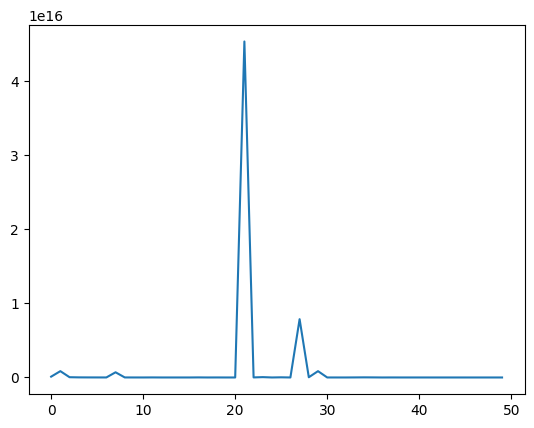

In [35]:
# plot the val loss
plt.plot(loss_progression)

In [36]:
# save the model
torch.save(model.state_dict(), 'model.pth')
